In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# These top lines are critical for import from another folder
sys.path.insert(0, 'C:/Users/14432/OneDrive/Research/Projects/A549_144hr/src/')
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/A549_144hr/src/memes/')

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
import ipywidgets as widgets
import random
import pandas as pd
import numpy as np 
from math import pi
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from pilutil import toimage

import os
from os.path import basename

from skimage.io import imread, imsave
from skimage.segmentation import watershed, clear_border
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, local_maxima, h_maxima, disk, dilation
from skimage.measure import regionprops, label
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from skimage import filters, img_as_float32, img_as_ubyte
from skimage.draw import rectangle_perimeter

import hj_util

In [2]:
def hmax_watershed(img, h_thresh, small_obj_thresh = 10, mask_thresh=0.15):
    """
    img - a 2d array for predicted edt image.
    h_thresh is between 0 to 1.
    """

    try:
        local_hmax = h_maxima(img, h_thresh)
    except ValueError:
        labels = np.zeros(img.shape)
        local_hmax_label = np.zeros(img.shape)
        return labels, local_hmax_label
    
    local_hmax_label = label(local_hmax, connectivity=1)
    labels = watershed(-img, local_hmax_label, mask=img > mask_thresh)
    
    return labels, local_hmax_label

def folder_watershed_labels(folder, h_thresh, small_obj_thresh = 10, mask_thresh = 0.15):
    """
    Obtain watershed masks for a edt image folder
    h_thresh - float between 0 to 1, quantil for watershed
    small_obj_thresh - int
    """
    folder = hj_util.folder_verify(folder)
    edt_files = hj_util.folder_file_num(folder)
    label_list = []
    for f in edt_files:
        edt = imread(f)
        edt_flat = edt[edt!=0.0].reshape(-1)
        h_thresh = np.quantile(edt_flat,h_thresh)
        mask_thresh = np.quantile(edt_flat,mask_thresh)
        label, local_hmax_label = hmax_watershed(edt, h_thresh, small_obj_thresh, mask_thresh)
        label = remove_small_objects(label, small_obj_thresh)
        label= clear_border(label)
        label_list.append(label)

    print("---------- Watershed processing is complete. -----------")
    return label_list

In [3]:
def list_select_by_index(the_list, index_list):
    """Return a list of selected items. """
    selected_elements = [the_list[index] for index in index_list]
    return selected_elements

def create_class_folders(class_list, aim_folder):
    """
    Create subfolders for each class in the aim folder.
    Return a list of subfolder path"""
    aim_folder = hj_util.folder_verify(aim_folder)
    c_folder_list = []
    
    i = 0
    while i<len(class_list):
        sub_folder = aim_folder+class_list[i]
#         hj_util.create_folder(sub_folder)
        c_folder_list.append(sub_folder)
        i = i+1
    return c_folder_list


def generating_img_label_list(img_list, label_list, img_name_list, size_thres1, size_thres2, roundness_thres,
                              img_selection = None, env_size = 50, bound_ext = 11,
                              num = 500, area_quantile = [0.15, 0.85], fractions = [0.2, 0.6, 0.2]):
    
    """
    img_list - list of np.array
    label_list - list of np.array
    
    num - int, number of total single cells
    img_selection - list of int, index for imgs that user choose to use.
    size_quantile - quantile for cell size threshold, between 0 to 1.
    fraction - fraction of small, mid, large cells.
    """
    
    if img_selection:
        img_list = list_select_by_index(img_list, img_selection)
        label_list = list_select_by_index(label_list, img_selection)
    
    img_list = np.array(img_list)
    label_list = np.array(label_list, dtype=np.int32)
    
    area_list = []
    img_thread = []
    label_thread = []
    env_list = []
    img_local_list = []
    label_local_list = []
    img_stat_list = []
    fr_idx_list = []
    
    i = 0
    while i<len(label_list):
        img = img_list[i]
        label = label_list[i]
        img_name = img_name_list[i]
        
        pos = img_name.split('_XY')[1][0]
        fr = img_name.split('_T')[1][:4]
        
        w, h = img.shape
#         if ((r+1.)/(c+1.)>15. or (c+1.)/(r+1.)>15. or r<4 or c<4):
#             i = i+1 
#             continue
        
        rps = regionprops(label)
        gen = (r for r in rps if r.area<size_thres1 or 4*pi*r.area/r.perimeter**2>roundness_thres and r.area<size_thres2)
        for r in gen:

            bound = r.bbox
            blank = np.zeros(label.shape)+1
            
            crop_b1 = bound[0]-bound_ext
            if crop_b1<=0:
                crop_b1=0
            crop_b2 = bound[2]+bound_ext
            if crop_b2>=w:
                crop_b2=w
            crop_b3 = bound[1]-bound_ext
            if crop_b3<=0:
                crop_b3=0
            crop_b4 = bound[3]+bound_ext
            if crop_b4>=h:
                crop_b4=h
            
            img_crop = img[crop_b1:crop_b2,crop_b3:crop_b4]
            label_crop = label[crop_b1:crop_b2,crop_b3:crop_b4]

            # generating env crop with box
            env_b1 = crop_b1-env_size
            if env_b1<=0:
                env_b1=0
            env_b2 = crop_b2+env_size
            if env_b2>=w:
                env_b2=w
            env_b3 = crop_b3-env_size
            if env_b3<=0:
                env_b3=0
            env_b4 = crop_b4+env_size
            if env_b4>=h:
                env_b4=h
                
            start = (crop_b1, crop_b3)
            end = (crop_b2, crop_b4)
            ww, hh = rectangle_perimeter(start, end=end, shape=img.shape)
            img_local = img.copy()
            label_local = label.copy()

            img_local[ww, hh] = np.min(img_local[env_b1:env_b2,env_b3:env_b4])
            env_crop = img_local[env_b1:env_b2,env_b3:env_b4]

            qt_b1 = crop_b1-round(img.shape[0]/4)
            if qt_b1<=0:
                qt_b1=0
            qt_b2 = crop_b2+round(img.shape[0]/4)
            if qt_b2>=w:
                qt_b2=w
            qt_b3 = crop_b3-round(img.shape[0]/4)
            if qt_b3<=0:
                qt_b3=0
            qt_b4 = crop_b4+round(img.shape[0]/4)
            if qt_b4>=h:
                qt_b4=h
            
            img_local[ww, hh] = np.min(img_local[qt_b1:qt_b2,qt_b3:qt_b4])

            img_local = img_local[qt_b1:qt_b2,qt_b3:qt_b4]
            label_local = label_local[qt_b1:qt_b2,qt_b3:qt_b4]

            img_thread.append(img_crop)
            label_thread.append(label_crop)
            area_list.append(r.area)
            env_list.append(env_crop)
            img_local_list.append(img_local)
            label_local_list.append(label_local)
            img_stat_list.append([pos,fr])
            fr_idx_list.append(i)            

        i = i+1
    
    inx = np.arange(len(img_thread))
    for img_idx in range(len(img_stat_list)):
        for stat_idx in range(len(img_stat_list[img_idx])):
            img_stat_list[img_idx][stat_idx] = np.int(img_stat_list[img_idx][stat_idx])
    img_stat_list = np.array(img_stat_list)
    
    if num and area_quantile and fractions:
        s_thre, l_thre = np.quantile(area_list, area_quantile)
        inx_s = []
        inx_m = []
        inx_l = []
        i = 0
        while i<len(area_list):
            if area_list[i]<s_thre:
                inx_s.append(i)
            elif area_list[i]<l_thre:
                inx_m.append(i)
            else:
                inx_l.append(i)
            i = i+1
            
        num_s = len(inx_s)
        num_m = len(inx_m)
        num_l = len(inx_l)
        
        num_s_need, num_m_need, num_l_need = np.int32(np.array(fractions) * 200)
        
        if num_s>num_s_need:
            inx_s = np.random.choice(inx_s, size=num_s_need, replace=False)
        if num_m>num_m_need:
            inx_s = np.random.choice(inx_m, size=num_m_need, replace=False)
        if num_l>num_l_need:
            inx_s = np.random.choice(inx_l, size=num_l_need, replace=False)
        inx = np.concatenate([inx_s, inx_m, inx_l])
        
        img_thread = list_select_by_index(img_thread, inx)
        label_thread = list_select_by_index(label_thread, inx)
        area_list = list_select_by_index(area_list, inx)
        env_list = list_select_by_index(env_list, inx)
    
    img_thread = np.array(img_thread)
    label_thread = np.array(label_thread)
    env_list = np.array(env_list)
    img_local_list = np.array(img_local_list)
    
    print("The total image number is: ", len(img_thread))
    return img_thread,label_thread, \
        env_list, \
        img_local_list, \
        img_stat_list

def color_num(labels):
    
    """draw color numbers on the center of the label"""
    label_rgb=label2rgb(labels,bg_label=0) # Return an RGB image where color-coded labels are painted over the image.
    img_rgb= toimage(label_rgb)
    base = img_rgb.convert('RGBA')
    # make a blank image for the text, initialized to transparent text color
    txt = Image.new('RGBA', base.size, (255,255,255,0))
    # get a font
    fnt = ImageFont.truetype('arial.ttf', 40)
    # get a drawing context
    d = ImageDraw.Draw(txt)
    for region in regionprops(labels):
        cx=int(region.centroid[1])     
        cy=int(region.centroid[0])
        d.text((cx,cy),str(labels[cy][cx]),font=fnt,fill=(255,255,255,255)) 
    out = Image.alpha_composite(base, txt)       
    return out  
    
def frame_img_label_show(env_list,img_thread,label_thread,img_stat_list,fr_list,fr_idx):
    
    list_idx = img_stat_list[:,1] == fr_list[fr_idx]
    fr_env_list = env_list[list_idx]
    fr_img_thread = img_thread[list_idx]
    fr_label_thread = label_thread[list_idx]
    fr_img_stat_list = img_stat_list[list_idx]
    
    fr_list_len = len(fr_env_list)
    for fr_list_idx in range(fr_list_len):
        fig = plt.figure(figsize = (5, 15))
        fig.add_subplot(1,3, 1)
        plt.imshow(fr_env_list[fr_list_idx], cmap = "gray")
        ax1 = plt.gca(); ax1.axes.xaxis.set_visible(False); ax1.axes.yaxis.set_visible(False)
        global crop_num
        ax1.title.set_text('fr '+str(fr_list[fr_idx]).zfill(4)+' crop '+str(crop_num+1).zfill(3))
        crop_num=crop_num+1
        fig.add_subplot(1,3, 2)
        plt.imshow(fr_img_thread[fr_list_idx], cmap = "gray")
        ax2 = plt.gca(); ax2.axes.xaxis.set_visible(False); ax2.axes.yaxis.set_visible(False)
        fig.add_subplot(1,3, 3)
        plt.imshow(fr_label_thread[fr_list_idx], cmap = "gray")
        ax3 = plt.gca(); ax3.axes.xaxis.set_visible(False); ax3.axes.yaxis.set_visible(False)
    
def make_img_list(img_folder):
    
    img_f = hj_util.folder_file_num(img_folder)
    img_list = []

    i = 0
    while i<len(img_f):
        
        img = imread(img_f[i])
        img_list.append(img)
        i = i+1
    return img_list

def make_name_list(img_folder):
    
    img_f = hj_util.folder_file_num(img_folder)
    img_name_list = []
    
    i = 0
    while i<len(img_f):
        
        img_name = basename(img_f[i])
        img_name_list.append(img_name)
        i = i+1
    return img_name_list

def make_fr_list(img_folder):
    
    img_f = hj_util.folder_file_num(img_folder)
    fr_list = []
    
    i = 0
    while i<len(img_f):
        
        img_name = basename(img_f[i])
        name_split = img_name.split('_T')
        curr_fr = int(name_split[1][:4])
        fr_list.append(curr_fr)
        i = i+1
    fr_list = np.array(fr_list)
    return fr_list

def single_cell_save(img, folder, pos, fr, i):
    
    folder = hj_util.folder_verify(folder)
    imsave(folder + 'XY' + str(pos) + '_fr' + str(fr) + '_cr' + str(i+1).zfill(3) +".tif", img.astype(np.uint32))

In [4]:
dat_dir = 'C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/'
img_folder = dat_dir + 'subsamps/XY3_Apop-IV/img/'
edt_folder = dat_dir + 'subsamps/XY3_Apop-IV/edt/'
crop_folder = dat_dir + "train/unclassified/"

start_idx = 0
end_idx = 11
n_fr = end_idx-start_idx

roundness_thres=0.8
size_thres1=9500
size_thres2=13000

img_list = make_img_list(img_folder)[start_idx:end_idx]
label_list = folder_watershed_labels(edt_folder, 0.85, small_obj_thresh = 1500, mask_thresh = 0.001)[start_idx:end_idx]
img_name_list = make_name_list(img_folder)[start_idx:end_idx]
fr_list = make_fr_list(img_folder)[start_idx:end_idx]

img_thread,label_thread, \
    env_list, \
    img_local_list, \
    img_stat_list = generating_img_label_list(
    img_list, label_list, img_name_list, size_thres1, size_thres2, roundness_thres, num=None)

for f in os.listdir(crop_folder):
    os.remove(os.path.join(crop_folder, f))
for i in range(len(img_thread)):
    single_cell_save(img_thread[i], crop_folder, img_stat_list[i][0], img_stat_list[i][1], i)

C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/subsamps/XY3_Apop-IV/img/ has 11 files
C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/subsamps/XY3_Apop-IV/edt/ has 11 files
---------- Watershed processing is complete. -----------
C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/subsamps/XY3_Apop-IV/img/ has 11 files
C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/subsamps/XY3_Apop-IV/img/ has 11 files
The total image number is:  1092


In [5]:
b1 = widgets.Button(
    description='next frame',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='check'
)

    
def init_globals():
    global fr_idx, crop_num
    fr_idx = 0
    crop_num = 0

def on_b1_clicked(b):
    global fr_idx
    fr_idx = fr_idx+1
    with out:
        clear_output()      
        if fr_idx<n_fr:
            print('XY ' + str(img_stat_list[fr_idx][0]) + ' fr ' + str(fr_list[fr_idx])+ \
                  ' ('+str(fr_idx+1)+'/'+str(n_fr)+')')
            frame_img_label_show(env_list,img_thread,label_thread,img_stat_list,fr_list,fr_idx)
            show_inline_matplotlib_plots()
        else:
            print("This is the end of pic queue.")

display(b1)
out = widgets.Output()
display(out)

init_globals()
with out:
    clear_output()
    print('XY ' + str(img_stat_list[fr_idx][0])+' fr ' + str(fr_list[fr_idx])+' ('+str(fr_idx+1)+'/'+str(n_fr)+')')
    frame_img_label_show(env_list,img_thread,label_thread,img_stat_list,fr_list,fr_idx)
    show_inline_matplotlib_plots()
        
b1.on_click(on_b1_clicked)

Button(button_style='info', description='next frame', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

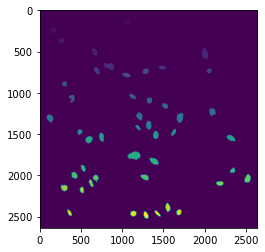

In [6]:
plt.imshow(label_list[0])